# Modeling

In [781]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB

In [782]:
# importing my cleaned dataframe for modeling
reddit_posts = pd.read_csv('Data/reddit_posts.csv')

In [783]:
reddit_posts.head()

,Title,ID,Author,URL,Score,Comment Count,Created,subreddit,processed_title,processed_title_joined
0,Things I Wish I Knew 8 Years Ago,4pl3yc,iamaliftaholic,https://www.reddit.com/r/Fitness/comments/4pl3...,19495,655,1.466744e+09,fitness,"['thing', 'wish', 'knew', 'year', 'ago']",thing wish knew year ago
1,How to do PULL UPS properly and how to do your...,7ye7r2,Antranik,https://www.reddit.com/r/Fitness/comments/7ye7...,14127,516,1.518960e+09,fitness,"['pull', 'ups', 'properly', 'first', 'pullup',...",pull ups properly first pullup ca
2,We over at r/flexibility created a new full-bo...,92bhaj,tykato,https://www.reddit.com/r/Fitness/comments/92bh...,14059,329,1.532689e+09,fitness,"['created', 'new', 'stretching', 'routine', 't...",created new stretching routine take minute inc...
3,"Smoking increases risk of lung cancer 2,500%. ...",3qft9h,duffstoic,https://www.reddit.com/r/Fitness/comments/3qft...,13341,1216,1.445964e+09,fitness,"['smoking', 'increase', 'risk', 'lung', 'cance...",smoking increase risk lung cancer bacon increa...
4,"Finally hit 213lbs lost, then got under 200lbs...",7nrqkz,abraxsis,https://www.reddit.com/r/Fitness/comments/7nrq...,12988,541,1.514948e+09,fitness,"['finally', 'hit', 'lost', 'got', 'square', 'i...",finally hit lost got square inch skin removed ...


## Baseline Accuracy

In [784]:
X = reddit_posts['processed_title_joined']
y = reddit_posts['subreddit']

In [785]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [786]:
most_frequent_class = y_train.mode()[0]

In [787]:
baseline_accuracy = (y_test == most_frequent_class).mean()
baseline_accuracy

0.5575167376749848

## Model 1 - CountVectorizer

In [788]:
cvec = CountVectorizer()
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer('\w+')

In [789]:
X = reddit_posts['processed_title_joined']
y = reddit_posts['subreddit']

In [790]:
X.isna().sum()

4

In [791]:
X.fillna('', inplace=True)

In [792]:
X.isna().sum()

0

In [793]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [794]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [795]:
model = MultinomialNB()
model.fit(X_train_cvec, y_train)

MultinomialNB()

In [796]:
model.score(X_train_cvec, y_train)

0.9576864535768645

In [797]:
model.score(X_test_cvec, y_test)

0.9360925136944613

In [798]:
y_pred = model.predict(X_test_cvec)

In [799]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

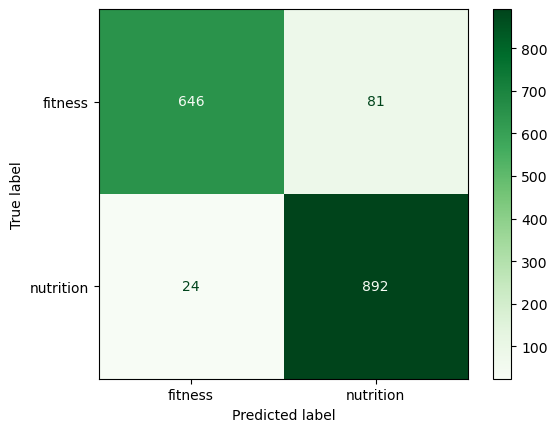

In [800]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Greens);

In [801]:
accuracy = accuracy_score(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)

In [802]:
accuracy

0.9360925136944613

In [803]:
class_rep

'              precision    recall  f1-score   support\n\n     fitness       0.96      0.89      0.92       727\n   nutrition       0.92      0.97      0.94       916\n\n    accuracy                           0.94      1643\n   macro avg       0.94      0.93      0.93      1643\nweighted avg       0.94      0.94      0.94      1643\n'

In [804]:
# Investigate incorrect predictions
incorrect_predictions = X_test[y_test != y_pred]
incorrect_true_labels = y_test[y_test != y_pred]
incorrect_pred_labels = y_pred[y_test != y_pred]

In [805]:
incorrect_df = pd.DataFrame({
    'Text': incorrect_predictions,
    'True Label': incorrect_true_labels,
    'Predicted Label': incorrect_pred_labels
})

In [806]:
incorrect_df.head(10)

,Text,True Label,Predicted Label
2992,squat even performed strict form cause stress ...,fitness,nutrition
4405,sub update addressing misinformation,nutrition,fitness
8135,favourite dietician follow instagram,nutrition,fitness
2829,first thing thought morning,fitness,nutrition
1053,water aerobics good muscle gain body toning,fitness,nutrition
2571,tooth health whey protein powder vitamin,fitness,nutrition
3238,got kidding cnn article stating fat healthy,fitness,nutrition
730,american heart association encourages focus si...,fitness,nutrition
239,interested would fititt community chemical ana...,fitness,nutrition
6011,someone please clarify question creatine,nutrition,fitness


In [807]:
incorrect_df.shape

(105, 3)

Now I'll investigate which words are most common in my incorrect predictions

In [808]:
cvec.fit(incorrect_df['Text'])

CountVectorizer()

In [809]:
incorrect_cvec = cvec.transform(incorrect_df['Text'])

In [810]:
incorrect_transformed = incorrect_cvec.toarray()

In [811]:
feature_names = cvec.get_feature_names_out()

In [812]:
incorrect_df = pd.DataFrame(incorrect_transformed, columns=feature_names)

In [813]:
incorrecttop20 = incorrect_df.sum().sort_values(ascending=False).head(20)
incorrecttop20

fat         11
calorie     11
healthy      9
help         8
health       8
diet         7
people       7
food         6
protein      6
body         6
day          5
good         5
exercise     5
eat          5
study        5
benefit      4
like         4
get          4
weight       4
eating       4
dtype: int64

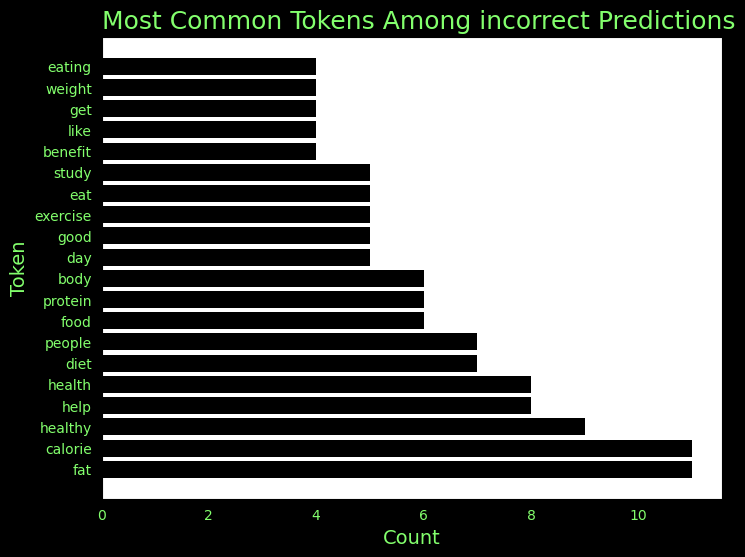

In [814]:
plt.figure(figsize=(8,6), facecolor='black')
ax = plt.axes()
plt.barh(incorrecttop20.index, incorrecttop20, color='black')
plt.title('Most Common Tokens Among incorrect Predictions', size=18, loc='left', color='#83ff6d')
plt.xlabel('Count', size=14, color='#83ff6d')
plt.xticks(color='#83ff6d')
plt.ylabel('Token', size=14, color='#83ff6d')
plt.yticks(color='#83ff6d')
plt.savefig('images/incorrect_tokens.png', dpi=192);

## Model #2 - TF-IDF 

In [873]:
X = reddit_posts['processed_title_joined']
y = reddit_posts['subreddit']

In [874]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [914]:
tfidf = TfidfVectorizer()

In [915]:
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [916]:
tf_feature_names = tfidf.get_feature_names_out()

In [917]:
tfidf_scores = X_train_tf.mean(axis=0).A1

In [918]:
tfidf_df = pd.DataFrame({'word':tf_feature_names, 'tfidf_score': tfidf_scores})

In [919]:
tfidf_df.head()

,word,tfidf_score
0,aa,0.000074
1,aap,0.000049
2,ab,0.001463
3,abdominal,0.000339
4,ability,0.000152


In [920]:
tfidf_df_sorted = tfidf_df.sort_values(by='tfidf_score', ascending=False)

In [921]:
tfidf_df_sorted.head(10)

,word,tfidf_score
3628,question,0.042156
4649,thread,0.040173
1102,daily,0.038872
4147,simple,0.037905
1775,food,0.018215
3570,protein,0.015476
2019,gym,0.013722
1247,diet,0.013691
2079,healthy,0.013351
632,calorie,0.011922


In [922]:
log = LogisticRegression(max_iter=1000)

In [923]:
log.fit(X_train_tf, y_train)

LogisticRegression(max_iter=1000)

In [924]:
y_pred = log.predict(X_test_tf)

In [925]:
log.score(X_train_tf, y_train)

0.9572298325722983

In [926]:
log.score(X_test_tf, y_test)

0.928180158247109

In [927]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

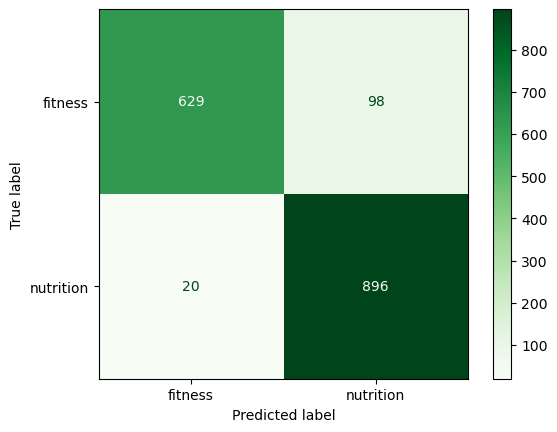

In [928]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Greens);

In [832]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.928180158247109

In [833]:
class_rep = classification_report(y_test, y_pred)
class_rep

'              precision    recall  f1-score   support\n\n     fitness       0.97      0.87      0.91       727\n   nutrition       0.90      0.98      0.94       916\n\n    accuracy                           0.93      1643\n   macro avg       0.94      0.92      0.93      1643\nweighted avg       0.93      0.93      0.93      1643\n'

In [834]:
incorrect_predictions = X_test[y_test != y_pred]
incorrect_true_labels = y_test[y_test != y_pred]
incorrect_pred_labels = y_pred[y_test != y_pred]

In [835]:
incorrect_tf = pd.DataFrame({
    'Text': incorrect_predictions,
    'True Label': incorrect_true_labels,
    'Predicted Label': incorrect_pred_labels
})

In [836]:
incorrect_tf.head(10)

,Text,True Label,Predicted Label
2992,squat even performed strict form cause stress ...,fitness,nutrition
2829,first thing thought morning,fitness,nutrition
1053,water aerobics good muscle gain body toning,fitness,nutrition
2970,would call curlbro ama,fitness,nutrition
2945,stopping wood evening,fitness,nutrition
2571,tooth health whey protein powder vitamin,fitness,nutrition
3238,got kidding cnn article stating fat healthy,fitness,nutrition
730,american heart association encourages focus si...,fitness,nutrition
239,interested would fititt community chemical ana...,fitness,nutrition
6011,someone please clarify question creatine,nutrition,fitness


In [837]:
incorrect_tf.shape

(118, 3)

In [838]:
cvec.fit(incorrect_tf['Text'])

CountVectorizer()

In [839]:
incorrect_tf_cvec = cvec.transform(incorrect_tf['Text'])

In [840]:
incorrect_tf_transformed = incorrect_tf_cvec.toarray()

In [841]:
feature_names = cvec.get_feature_names_out()

In [842]:
incorrect_tf = pd.DataFrame(incorrect_tf_transformed, columns=feature_names)

In [843]:
incorrecttop20tf = incorrect_tf.sum().sort_values(ascending=False).head(20)
incorrecttop20tf

fat         12
calorie     10
healthy      9
health       8
protein      7
people       7
day          6
diet         6
body         6
food         6
good         6
help         5
get          5
eat          5
muscle       5
much         4
question     4
would        4
exercise     4
study        4
dtype: int64

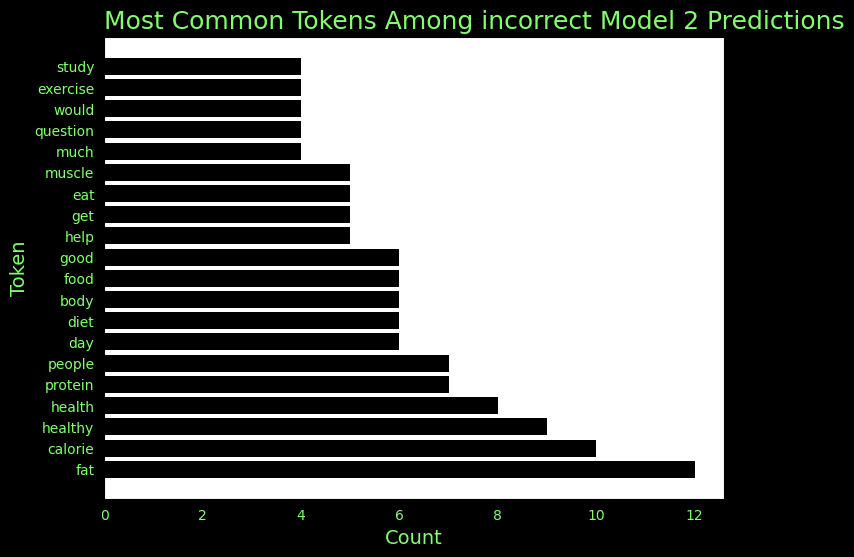

In [844]:
plt.figure(figsize=(8,6), facecolor='black')
ax = plt.axes()
plt.barh(incorrecttop20tf.index, incorrecttop20tf, color='black')
plt.title('Most Common Tokens Among incorrect Model 2 Predictions', size=18, loc='left', color='#83ff6d')
plt.xlabel('Count', size=14, color='#83ff6d')
plt.xticks(color='#83ff6d')
plt.ylabel('Token', size=14, color='#83ff6d')
plt.yticks(color='#83ff6d')
plt.savefig('images/incorrect_tokens_2.png', dpi=192);

## Model 3: CVEC with Bigrams & GridSearch

In [845]:
X = reddit_posts['processed_title_joined']
y = reddit_posts['subreddit']

In [846]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [847]:
cvec = CountVectorizer(ngram_range=(1, 2), max_features=10000)

In [848]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [849]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=8)
grid.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [850]:
best_model = grid.best_estimator_

In [851]:
y_pred = best_model.predict(X_test_cvec)

In [852]:
best_model.score(X_train_cvec, y_train)

0.9951293759512938

In [853]:
best_model.score(X_test_cvec, y_test)

0.938527084601339

In [854]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

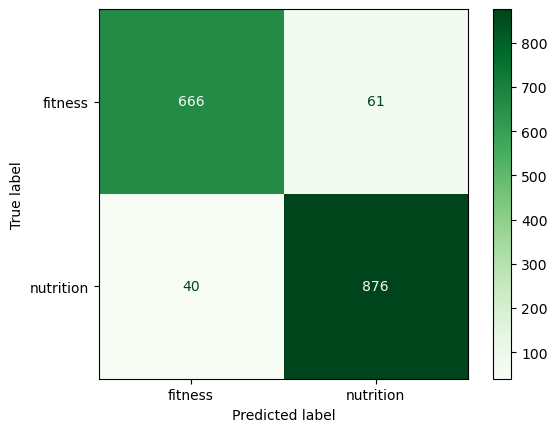

In [855]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Greens);

In [856]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.938527084601339

In [857]:
class_rep = classification_report(y_test, y_pred)
class_rep

'              precision    recall  f1-score   support\n\n     fitness       0.94      0.92      0.93       727\n   nutrition       0.93      0.96      0.95       916\n\n    accuracy                           0.94      1643\n   macro avg       0.94      0.94      0.94      1643\nweighted avg       0.94      0.94      0.94      1643\n'

In [858]:
incorrect_predictions = X_test[y_test != y_pred]
incorrect_true_labels = y_test[y_test != y_pred]
incorrect_pred_labels = y_pred[y_test != y_pred]

In [859]:
incorrect_bi = pd.DataFrame({
    'Text': incorrect_predictions,
    'True Label': incorrect_true_labels,
    'Predicted Label': incorrect_pred_labels
})

In [860]:
incorrect_bi.head(10)

,Text,True Label,Predicted Label
4405,sub update addressing misinformation,nutrition,fitness
4270,important exercise compared diet,nutrition,fitness
7277,lot look older weaker,nutrition,fitness
2829,first thing thought morning,fitness,nutrition
4535,better eating great diet getting much exercise...,nutrition,fitness
6911,low carb diet week result,nutrition,fitness
2945,stopping wood evening,fitness,nutrition
2571,tooth health whey protein powder vitamin,fitness,nutrition
3238,got kidding cnn article stating fat healthy,fitness,nutrition
239,interested would fititt community chemical ana...,fitness,nutrition


In [861]:
cvec.fit(incorrect_bi['Text'])

CountVectorizer(max_features=10000, ngram_range=(1, 2))

In [862]:
incorrect_bi_cvec = cvec.transform(incorrect_bi['Text'])

In [863]:
incorrect_bi_transformed = incorrect_bi_cvec.toarray()

In [864]:
feature_names = cvec.get_feature_names_out()

In [865]:
incorrect_bi_df = pd.DataFrame(incorrect_bi_transformed, columns=feature_names)

In [866]:
incorrecttop20bi = incorrect_bi_df.sum().sort_values(ascending=False).head(20)
incorrecttop20bi

fat         10
diet         9
healthy      8
calorie      8
protein      7
muscle       6
health       6
food         6
eat          5
get          5
good         5
eating       5
exercise     5
week         5
day          5
study        4
people       4
help         4
body         4
much         4
dtype: int64

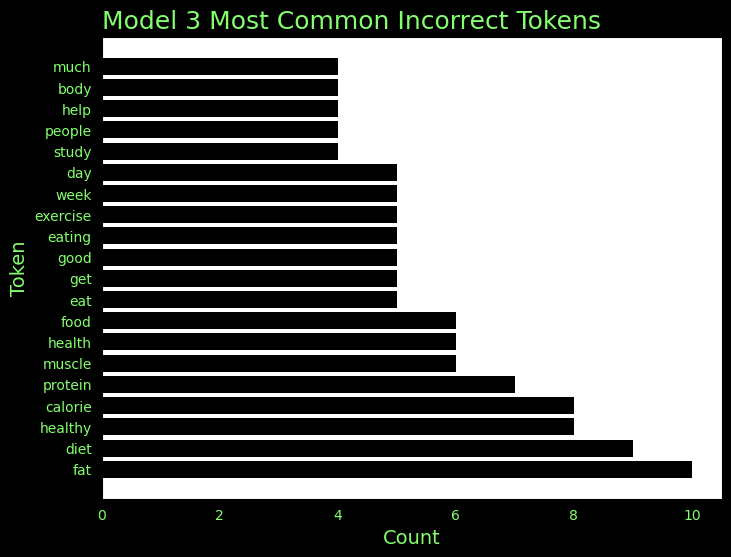

In [867]:
plt.figure(figsize=(8,6), facecolor='black')
ax = plt.axes()
plt.barh(incorrecttop20bi.index, incorrecttop20bi, color='black')
plt.title('Model 3 Most Common Incorrect Tokens', size=18, loc='left', color='#83ff6d')
plt.xlabel('Count', size=14, color='#83ff6d')
plt.xticks(color='#83ff6d')
plt.ylabel('Token', size=14, color='#83ff6d')
plt.yticks(color='#83ff6d')
plt.savefig('images/incorrect_tokens_3.png', dpi=192);

In [929]:
reddit_posts.to_csv('Data/reddit_posts_tokenized.csv', index=False)